In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_probability as tfp

from tqdm import tqdm
import pandas
import statistics
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets
import numpy as np
import sklearn
import sklearn.datasets
import sklearn.linear_model

tfk = tf.keras
tfkl = tf.keras.layers
tfd = tfp.distributions
tfpl = tfp.layers
tfb = tfp.bijectors
tfd = tfp.distributions

In [ ]:
def rescale_columns(data):
  for i in range(data.shape[1]):
    mmin = min(data[:,i])
    mmax = max(data[:,i])
    data[:,i] = (data[:,i] - mmin) / (mmax-mmin)
  return data

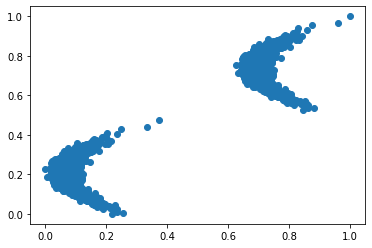

In [ ]:
def get_two_banana_dataset():
  # from https://www.tensorflow.org/probability/api_docs/python/tfp/bijectors/AutoregressiveNetwork?hl=zh-cn
  # Generate data -- as in Figure 1 in [Papamakarios et al. (2017)][2]).
  # [2]: George Papamakarios, Theo Pavlakou, Iain Murray, Masked Autoregressive Flow for Density Estimation. In Neural Information Processing Systems, 2017. https://arxiv.org/abs/1705.07057
  
  np.random.seed(1)
  n = 2000
  x2 = np.random.randn(n).astype(dtype=np.float32) * 2.
  x1 = np.random.randn(n).astype(dtype=np.float32) + (x2 * x2 / 4.)
  x2 = (x2-min(x2))/max(x2)
  x1 = (x1-min(x1))/max(x1)
  data = np.stack([x1, x2], axis=-1)
  data = np.concatenate((data,data+2))
  data = rescale_columns(data).astype(np.float32)
  labels = np.array([0 for i in range(len(x1))] + [1 for i in range(len(x2))])
  np.random.seed(None)
  
  return data, labels

samples, labels = get_two_banana_dataset()

plt.scatter(samples[:,0],samples[:,1])

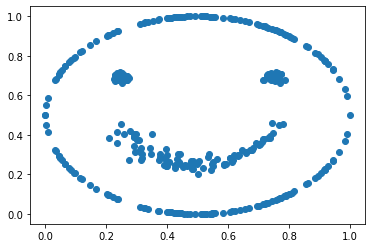

In [ ]:
def get_smile_dataset():
  # from https://profs.info.uaic.ro/~pmihaela/DM/datasets%20clustering/
  all=pandas.read_csv("smile.csv").to_numpy().astype(np.float32)
  samples = all[:,:2]
  labels = all[:,2]
  samples = rescale_columns(samples)
  return samples, labels.astype(np.uint8)

samples, labels = get_smile_dataset()

plt.scatter(samples[:,0],samples[:,1])

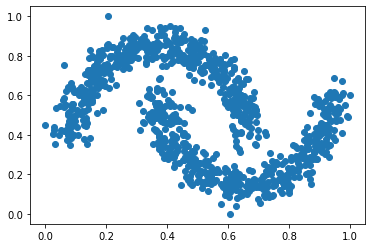

In [ ]:
def get_moons_dataset():
  np.random.seed(1)
  all = sklearn.datasets.make_moons(1000,noise=0.1)
  samples=all[0].astype(np.float32)
  labels = all[1]
  samples = rescale_columns(samples)
  np.random.seed(None)
  
  return samples, labels

samples, labels = get_moons_dataset()

plt.scatter(samples[:,0],samples[:,1])

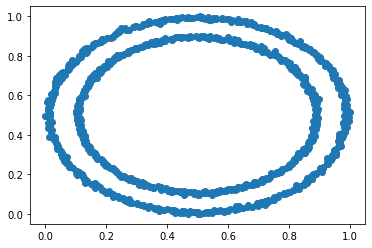

In [ ]:
def get_circles_dataset():
  np.random.seed(1)
  all = sklearn.datasets.make_circles(1000,noise=0.01)
  samples=all[0].astype(np.float32)
  labels = all[1]
  samples = rescale_columns(samples)
  np.random.seed(None)
  
  return samples, labels

samples, labels = get_circles_dataset()

plt.scatter(samples[:,0],samples[:,1])

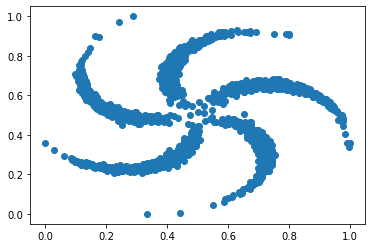

In [ ]:
def get_pinwheel_dataset():
  # from https://github.com/emtiyaz/vmp-for-svae/blob/master/data.py
  def make_pinwheel_data(radial_std, tangential_std, num_classes, num_per_class, rate):
    # code from Johnson et. al. (2016)
    rads = np.linspace(0, 2*np.pi, num_classes, endpoint=False)

    np.random.seed(1)

    features = np.random.randn(num_classes*num_per_class, 2) \
        * np.array([radial_std, tangential_std])
    features[:,0] += 1.
    labels = np.repeat(np.arange(num_classes), num_per_class)

    angles = rads[labels] + rate * np.exp(features[:,0])
    rotations = np.stack([np.cos(angles), -np.sin(angles), np.sin(angles), np.cos(angles)])
    rotations = np.reshape(rotations.T, (-1, 2, 2))

    feats = 10 * np.einsum('ti,tij->tj', features, rotations)

    data = np.random.permutation(np.hstack([feats, labels[:, None]]))

    np.random.seed(None)

    return data[:, 0:2], data[:, 2].astype(np.int)

  nb_spokes = 5
  samples, labels = make_pinwheel_data(0.3, 0.05, nb_spokes, 512, 0.25)

  samples = samples.astype(np.float32)

  samples = rescale_columns(samples)

  return samples, labels

samples, labels = get_pinwheel_dataset()

plt.scatter(samples[:,0],samples[:,1])

In [ ]:
y_train = labels
k=len(np.unique(labels))

In [ ]:
# k=10

# data_name = "mnist"

# import tensorflow as tf
# mnist = tf.keras.datasets.fashion_mnist
# (x_train, y_train),(x_test, y_test) = mnist.load_data()
# x_train = np.concatenate((x_train,x_test))
# y_train = np.concatenate((y_train,y_test))
# x_train=(x_train.reshape((x_train.shape[0],-1))/255.).astype(np.float32)

# x_train = x_train[y_train < k]
# y_train = y_train[y_train < k]

# data = x_train
# samples = data

# print(samples.shape)

In [ ]:
BATCH_SIZE = 4000
SHUFFLE_BUFFER_SIZE = 4000

dataset_aux = tf.data.Dataset.from_tensor_slices(samples)
dataset = dataset_aux.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
dataset_not_shuffled = dataset_aux.batch(BATCH_SIZE)

In [ ]:
D = samples.shape[1]

distribution = tfd.Mixture(
  cat=tfd.Categorical(
      logits=tf.Variable([1.0 for i in range(k)],dtype=tf.float32)),
  components=[tfd.TransformedDistribution(
  distribution=tfd.MultivariateNormalDiag(
        loc=np.random.rand(D).astype(np.float32),#kmeans.cluster_centers_[i],
        scale_diag=[0.1 for _ in range(D)]),#scale_diag=np.std(samples,axis=0)),
  bijector=tfb.MaskedAutoregressiveFlow(
      tfb.AutoregressiveNetwork(params=2, hidden_units=[10],activation="tanh")
  )) for i in range(k)])
  # bijector=tfb.RealNVP(
  #       num_masked=1,
  #       shift_and_log_scale_fn=tfb.real_nvp_default_template(
  #           hidden_layers=[512,512],activation="relu"))) for i in range(k)])

def nll(distribution,samples):
  return -tf.reduce_mean(distribution.log_prob(samples))

def get_loss_and_grads(distribution,samples):
  with tf.GradientTape() as tape:
    tape.watch(distribution.trainable_variables)
    # print(distribution.trainable_variables)
    loss = nll(distribution,samples)
    grads = tape.gradient(loss, distribution.trainable_variables)
  return loss, grads

In [ ]:
def plot(log=True):
  # from https://tiao.io/post/building-probability-distributions-with-tensorflow-probability-bijector-api/
  data = samples
  u1_lim = min(data[:,0]), max(data[:,0])
  u2_lim = min(data[:,1]), max(data[:,1])

  u1 = tf.linspace(*u1_lim, 100)
  u2 = tf.linspace(*u2_lim, 100)
  u_grid = tf.stack(tf.meshgrid(u1, u2), axis=-1)

  fig, ax = plt.subplots(figsize=(6, 5))

  if log:
    ax.set_title('log density log$p_{X}(\mathbf{x})$')
    cb = ax.pcolormesh(u1, u2, distribution.log_prob(u_grid), cmap='inferno')
  else:
    ax.set_title('density $p_{X}(\mathbf{x})$')
    cb = ax.pcolormesh(u1, u2, distribution.prob(u_grid), cmap='inferno')

  fig.colorbar(cb, ax=ax)

  ax.set_xlim(u1_lim)
  ax.set_ylim(u2_lim)

  ax.set_xlabel('$x_1$')
  ax.set_ylabel('$x_2$')

  plt.show()

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Sebi\anaconda3\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


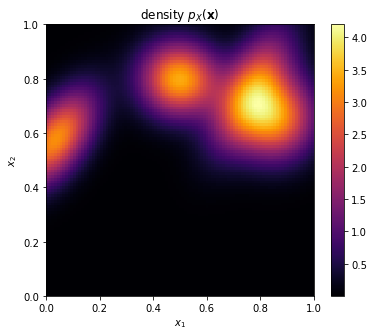

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.35s/it]


In [ ]:
epochs = 1
optimizer = tf.keras.optimizers.Adam()
losses = []
for _ in tqdm(range(epochs)):
  # print(_)
  mean_loss = 0
  count = 0
  for batch in dataset:
    loss, grads = get_loss_and_grads(distribution,batch)
    del batch
    optimizer.apply_gradients(zip(grads, distribution.trainable_variables))
    mean_loss += loss
    count+=1
    if np.isnan(loss):
      break
    del loss
    del grads
  mean_loss/=count
  # plot(False)
  # print(mean_loss.numpy())
  if _ % 100 == 0:
    plot(False)
  #   print(mean_loss)
  losses.append(mean_loss)

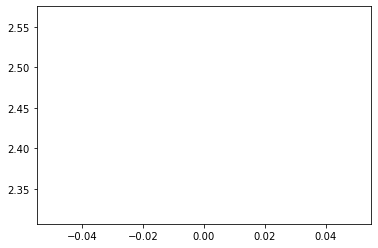

In [ ]:
plt.plot(losses)

C:\Users\Sebi\anaconda3\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


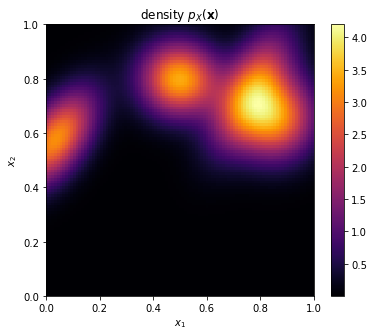

In [ ]:
plot(False)

In [ ]:
def predict(samples):
  dist_cat_log_probs = [distribution.cat.log_prob(i) for i in range(k)]
  clustering=[]
  counter=0
  dataset_aux = tf.data.Dataset.from_tensor_slices(samples.astype(np.float32))
  dataset_not_shuffled = dataset_aux.batch(BATCH_SIZE)
  for batch in dataset_not_shuffled:
    counter+=1
    # print(counter)
    dist_components_weigthed_log_probs = np.zeros((k,len(batch)))
    for i in range(k):
      dist_components_weigthed_log_probs[i,:] = dist_cat_log_probs[i] + distribution.components[i].log_prob(batch)
    clustering += list(np.argmax(dist_components_weigthed_log_probs, axis=0))
  clustering = np.array(clustering)
  return clustering

clustering = predict(samples)

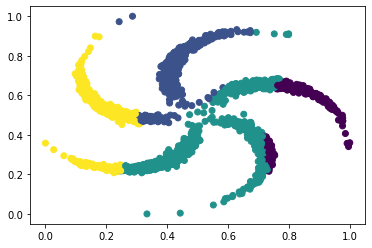

In [ ]:
plt.scatter(samples[:,0],samples[:,1],c=clustering)

In [ ]:
#@title Helper function
# from https://raw.githubusercontent.com/aciobanusebi/ml2/master/planar_utils_modified.py
def plot_decision_boundary(model, X, y):
    X = X.T
    y = y[np.newaxis,...]
    # Set min and max values and give it some padding
    x_min, x_max = -0.25, 1.25
    y_min, y_max = -0.25, 1.25
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y[0,:], cmap=plt.cm.Spectral)

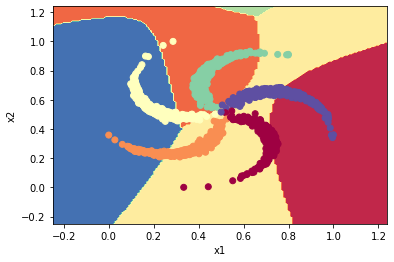

In [ ]:
plot_decision_boundary(lambda x: predict(x), samples, np.array(labels))

In [ ]:
# !pip install coclust

In [ ]:
from sklearn import metrics

def purity_score(y_true, y_pred): # from https://stackoverflow.com/a/51672699/7947996; in [0,1]; 0-bad,1-good
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix) 

from sklearn.metrics.cluster import adjusted_rand_score # in [0,1]; 0-bad,1-good
from sklearn.metrics.cluster import normalized_mutual_info_score # in [0,1]; 0-bad,1-good

from coclust.evaluation.external import accuracy # in [0,1]; 0-bad,1-good; install it via "!pip install coclust" in Google Colab

C:\Users\Sebi\anaconda3\lib\site-packages\sklearn\utils\linear_assignment_.py:22: FutureWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


In [ ]:
print(purity_score(y_train,clustering))
print(adjusted_rand_score(y_train,clustering))
print(normalized_mutual_info_score(y_train,clustering))
print(accuracy(y_train,clustering))

0.628125
0.44694866388517546
0.5903529227223373
0.628125


C:\Users\Sebi\anaconda3\lib\site-packages\sklearn\utils\linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


In [ ]:
import sklearn.metrics
matrix = sklearn.metrics.cluster.contingency_matrix(y_train, clustering)
print(matrix)
print(matrix/matrix.sum(axis=1, keepdims=True))

[[145   0 367   0]
 [  0   0 438  74]
 [  0  65   1 446]
 [  0 507   5   0]
 [217   7 288   0]]
[[0.28320312 0.         0.71679688 0.        ]
 [0.         0.         0.85546875 0.14453125]
 [0.         0.12695312 0.00195312 0.87109375]
 [0.         0.99023438 0.00976562 0.        ]
 [0.42382812 0.01367188 0.5625     0.        ]]
